## Libraries Imported

In [2]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset, random_split
from transformers import AdamW, get_linear_schedule_with_warmup
import numpy as np
from sklearn.metrics import accuracy_score
import pandas as pd
import random
import time
from datetime import timedelta
from sklearn.model_selection import StratifiedKFold
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import ast
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

## Library Description:
- `torch`: A deep learning library for building and training neural networks.
- `transformers`: A library pre-trained transformer models for NLP tasks.
- `CrossEntropyLoss`: A PyTorch loss function for multi-class classification problems.
- `DataLoader`: A PyTorch utility to efficiently load and batch data.
- `RandomSampler`, `SequentialSampler`: Tools for shuffling or ordering data in PyTorch DataLoader.
- `TensorDataset`: A PyTorch dataset class for combining tensors.
- `random_split`: A PyTorch function to split datasets into train/test subsets.
- `AdamW`: An optimizer to train deep learning models with weight decay.
- `get_linear_schedule_with_warmup`: A learning rate scheduler for gradual warmup and linear decay.
- `numpy`: The library to perform numerical computation and array manipulation.
- `accuracy_score`: A metric to calculate the proportion of correct predictions.
- `pandas`: A library to manipulate and analyze data.
- `random`: Module that provides functionality for generating random numbers and shuffling data.
- `time`: Module used to measure runtime, basically anything that involves time or time-related operations.
- `timedelta`: Class used to calculate the difference between two dates and times.
- `StratifiedKFold`: Technique of cross-validation that creates folds for stratification.
- `tqdm`: Library for creating progress bars.
- `precision_score`, `recall_score`, `f1_score`: Parameters for classification results.
- `ast`: Module used for parsing and analyzing Python abstract syntax trees.
- `matplotlib.pyplot`: A library to create visualizations and plots.
- `confusion_matrix`: Metric to assess the predictions of the model in classification tasks.
```


## DataSet Preparation

In [6]:
import torch
from transformers import BertTokenizer
import pandas as pd

def tokenize_dataset(dataset, tokenizer, max_len=512):
    """
    
   Here, Tokenizes the input dataset using BERT's tokenizer.
   One abstract is truncated to 'max_len'.
   Here, the tokenized inputs are returned along with attention masks.
    
    """
    input_ids = []
    attention_masks = []

    try:
        # Iterating over each abstract in the dataset
        for abstract in dataset['Abstract_Tokens']:
            # Encoding each abstract respectively
            encoded_dict = tokenizer.encode_plus(
                abstract,
                add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
                max_length=max_len,       # Pad or truncate to max_len
                truncation=True,          # Truncate longer sequences
                padding='max_length',     # Pad shorter sequences
                return_attention_mask=True,  # Generate attention masks
                return_tensors='pt',      # Return PyTorch tensors
            )
            input_ids.append(encoded_dict['input_ids'][0])
            attention_masks.append(encoded_dict['attention_mask'][0])

        # Convert lists to tensors
        input_ids = torch.stack(input_ids, dim=0)
        attention_masks = torch.stack(attention_masks, dim=0)

        # Convert labels to tensors
        labels = torch.tensor(dataset['label'].values)

        return input_ids, attention_masks, labels

    except KeyError as e:
        print(f"KeyError: {e}. Please ensure the dataset contains the required column 'Abstract_Tokens'.")
        return None, None, None
    except Exception as e:
        print(f"An error occurred during tokenization: {e}")
        return None, None, None


# Load the dataset
try:
    df = pd.read_csv('output_file.csv')  # Use the output file from your preprocessing step
    print("Dataset loaded successfully.")

    # Ensure the required columns exist
    if 'Abstract_Tokens' not in df.columns or 'Category' not in df.columns:
        raise ValueError("The dataset must contain 'Abstract_tokens' and 'Category' columns.")

    # Map category labels to numeric values
    df['label'] = df['Category'].map({'Astronomy': 0, 'Political Science': 1, 'Psychology': 2})

    if df['label'].isnull().any():
        raise ValueError("The 'Category' column contains unknown labels. Ensure all categories are mapped correctly.")

    print("Total number of abstracts in the dataset:", df.shape[0])

    # Initialize the BERT tokenizer
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

    # Tokenize the dataset
    input_ids, attention_masks, labels = tokenize_dataset(df, tokenizer)

    if input_ids is not None:
        print("Tokenization completed successfully.")
        print(f"Input IDs shape: {input_ids.shape}")
        print(f"Attention Masks shape: {attention_masks.shape}")
        print(f"Labels shape: {labels.shape}")
    else:
        print("Tokenization failed. Please check your dataset and parameters.")

except FileNotFoundError as e:
    print(f"FileNotFoundError: {e}. Ensure the file 'output_file.csv' exists in the specified directory.")
except ValueError as e:
    print(f"ValueError: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


Dataset loaded successfully.
Total number of abstracts in the dataset: 1065
Tokenization completed successfully.
Input IDs shape: torch.Size([1065, 512])
Attention Masks shape: torch.Size([1065, 512])
Labels shape: torch.Size([1065])


## Tokenizing the dataset

In [7]:
# Convert tensors to lists for saving in CSV
input_ids_list = input_ids.numpy().tolist()
attention_masks_list = attention_masks.numpy().tolist()
labels_list = labels.numpy().tolist()

# Create a new DataFrame for saving to CSV
tokenized_data = pd.DataFrame({
    'input_ids': input_ids_list,
    'attention_masks': attention_masks_list,
    'labels': labels_list
})

# Save the DataFrame to a new CSV file
tokenized_data.to_csv('token_dataset.csv', index=False)

print("Tokenized dataset has been saved to 'token_dataset.csv'")


Tokenized dataset has been saved to 'token_dataset.csv'


### Explanation of the Code:

#### Function: `tokenize_dataset`

- **Parameters:**
  - `dataset`: Input dataset containing abstracts and corresponding labels.
  - `tokenizer`: BERT tokenizer used for transforming text into tokenized format.
  - `max_len`: Maximum token sequence length, ensuring truncation or padding.

- **Functionality:**
  - Tokenizes the abstracts using BERT's tokenizer while handling truncation or padding to match `max_len`.
  - Outputs tokenized `input_ids`, attention masks, and labels, ready for model input.

#### Data Loading and Preprocessing:

- **Dataset Loading:**
  - Loads a CSV file (`output_file.csv`) into a DataFrame (`df`) containing preprocessed abstracts in the column `abstract`.

- **Label Encoding:**
  - Maps textual labels (`'Astronomy'`, `'Political Science'`, `'Psychology'`) to numeric values (`0`, `1`, `2`) for compatibility with machine learning models.
  - Adds a new column `label` to store numeric labels.

#### Tokenization and Data Preparation:

- **Tokenizer Initialization:**
  - Sets up the BERT tokenizer (`bert-base-uncased`), ensuring case insensitivity during text processing.

- **Dataset Tokenization:**
  - Uses the `tokenize_dataset` function to process abstracts into tokenized inputs (`input_ids`), attention masks, and labels.

- **Conversion to Lists:**
  - Converts the tokenized tensors (`input_ids`, `attention_masks`, `labels`) to lists for compatibility with file-saving operations.

#### DataFrame Creation and Export:

- **DataFrame Construction:**
  - Creates a new DataFrame (`tokenized_data`) with columns: 
    - `input_ids`: Encoded token sequences.
    - `attention_masks`: Binary masks indicating padded tokens.
    - `labels`: Numeric labels.

- **Saving as CSV:**
  - Exports the tokenized data to a CSV file (`tokenized_dataset.csv`) without index values (`index=False`), ensuring a clean format for future use.


#### Final Output:

- **Completion Message:**
  - Confirms the successful export of the tokenized dataset to `tokenized_dataset.csv`, ready for subsequent training steps.

## Loading the Model

In [8]:
# Load BertForSequenceClassification, the pretrained BERT model with a single linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=3,  # The number of output labels--3 for your classification task.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

print("Model loaded successfully.")

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Model loaded successfully.


## The Training Loop

## Transfer to Device

In [9]:
# Check if GPU is available and use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Send the model to the device (GPU or CPU)
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [10]:
# Seed for reproducibility
seed_val = 42
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# Freeze all layers of the model except the classification layer
for param in model.bert.parameters():
    param.requires_grad = False

# Initializing lists to store metrics for all folds
all_folds_train_losses = []
all_folds_val_losses = []
all_folds_train_accuracies = []
all_folds_val_accuracies = []

# Prepare for K-Fold Cross-Validation
n_splits = 5
batch_size = 32
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed_val)
loss_function = CrossEntropyLoss()

# Before starting the K-Fold Cross-Validation
all_true_labels = []
all_predictions = []

# K-Fold Cross-Validation
for fold, (train_idx, val_idx) in enumerate(skf.split(input_ids, labels.numpy())):
    print(f'\n======== Fold {fold + 1} / {n_splits} ========')

    # Lists to store metrics for the current fold
    fold_train_losses = []
    fold_val_losses = []
    fold_train_accuracies = []
    fold_val_accuracies = []
    fold_predictions = []
    fold_true_labels = []
    
    # Create training and validation subsets for the current fold
    train_subset = TensorDataset(input_ids[train_idx], attention_masks[train_idx], labels[train_idx])
    val_subset = TensorDataset(input_ids[val_idx], attention_masks[val_idx], labels[val_idx])

    # Create dataloaders for training and validation subsets
    train_dataloader = DataLoader(train_subset, sampler=RandomSampler(train_subset), batch_size=batch_size)
    validation_dataloader = DataLoader(val_subset, sampler=SequentialSampler(val_subset), batch_size=batch_size)

    # AdamW is a class from the huggingface library
    optimizer = AdamW(model.parameters(),
                      lr=5e-5,  # Learning rate
                      eps=1e-8  # Epsilon to prevent division by zero in optimizer updates
    )

    # Number of training epochs
    epochs = 4

    # Total number of training steps is the number of batches per epoch times the number of epochs
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler to decrease the learning rate as training progresses
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=0,  # No warmup steps
                                            num_training_steps=total_steps)

    print("Optimizer and scheduler set up successfully.")
        
    # Training Loop
    for epoch_i in range(0, epochs):
        print(f'\nEpoch {epoch_i + 1} / {epochs}')
        print('Training...')
        start_time_epoch = time.time()

        total_train_loss = 0
        total_train_accuracy = 0
        model.train()

        for batch in tqdm(train_dataloader, desc='Training', leave=False):
            start_time_batch = time.time()

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            model.zero_grad()        
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            loss = outputs.loss
            total_train_loss += loss.item()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()

            # Calculate batch accuracy
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).flatten()
            batch_accuracy = (preds == b_labels).cpu().numpy().mean()
            total_train_accuracy += batch_accuracy

            elapsed_time_batch = str(timedelta(seconds=int(round(time.time() - start_time_batch))))
            print(f"Batch Loss: {loss.item():.4f}, Time: {elapsed_time_batch}", end='\r')

        elapsed_time_epoch = str(timedelta(seconds=int(round(time.time() - start_time_epoch))))
        avg_train_loss = total_train_loss / len(train_dataloader)
        fold_train_losses.append(avg_train_loss)
        train_accuracy_for_this_epoch = total_train_accuracy / len(train_dataloader)
        fold_train_accuracies.append(train_accuracy_for_this_epoch)
        print(f"\nAverage training loss: {avg_train_loss:.2f} | Epoch Time: {elapsed_time_epoch}")
        print(f"\nTraining Accuracy for this Epoch: {train_accuracy_for_this_epoch:.2f} | Epoch Time: {elapsed_time_epoch}")

        # Validation Loop
        print('\nValidation...')
        start_time_epoch = time.time()
        model.eval()
        total_eval_loss = 0
        total_eval_accuracy = 0
        nb_eval_steps = 0  # Count the number of validation steps (batches)

        for batch in tqdm(validation_dataloader, desc='Validation', leave=False):
            start_time_batch = time.time()

            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits
                # Compute validation loss
                loss = loss_function(logits, b_labels)
                total_eval_loss += loss.item()

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()
            # label_ids = b_labels.to('cuda').numpy()
            
            # Calculate and accumulate batch accuracy
            tmp_eval_accuracy = accuracy_score(label_ids, np.argmax(logits, axis=1).flatten())
            total_eval_accuracy += tmp_eval_accuracy
            nb_eval_steps += 1  # Increment the count of validation steps

            elapsed_time_batch = str(timedelta(seconds=int(round(time.time() - start_time_batch))))
            print(f"Batch Loss: {loss.item():.4f}, Time: {elapsed_time_batch}", end='\r')

        elapsed_time_epoch = str(timedelta(seconds=int(round(time.time() - start_time_epoch))))
        # Calculate the average validation loss and accuracy for the epoch
        avg_val_loss = total_eval_loss / nb_eval_steps
        avg_val_accuracy = total_eval_accuracy / nb_eval_steps
        fold_val_losses.append(avg_val_loss)
        fold_val_accuracies.append(avg_val_accuracy)

        print(f"\nAverage Validation Loss: {avg_val_loss:.2f} | Epoch Time: {str(timedelta(seconds=int(round(time.time() - start_time_epoch))))}")
        print(f"\nValidation Accuracy for this Epoch: {avg_val_accuracy:.2f} | Epoch Time: {str(timedelta(seconds=int(round(time.time() - start_time_epoch))))}")
        
    # Accumulate predictions and true labels only after the final epoch of the fold
    if epoch_i == epochs - 1:
        print('\nCollecting predictions and labels from the final epoch of the fold...')
        for batch in tqdm(validation_dataloader, desc='Final Epoch Validation', leave=False):
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            batch_predictions = np.argmax(logits, axis=1)
            all_predictions.extend(batch_predictions)
            all_true_labels.extend(label_ids)  
            
    # After the last epoch of the fold, calculate and print the confusion matrix
    if epoch_i == epochs - 1:
        print('\nCalculating confusion matrix for the final epoch of the fold...')

        # Ensure model is in evaluation mode
        model.eval()

        # Iterate over the validation data
        for batch in validation_dataloader:
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            with torch.no_grad():
                outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
                logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            batch_predictions = np.argmax(logits, axis=1)
            fold_predictions.extend(batch_predictions)
            fold_true_labels.extend(label_ids)

        # Calculate the confusion matrix for this fold
        cm = confusion_matrix(fold_true_labels, fold_predictions)
        print(f"\nConfusion Matrix for Fold {fold + 1}:")
        print(cm)       
        
        # Append fold metrics to overall lists
        all_folds_train_losses.append(fold_train_losses)
        all_folds_val_losses.append(fold_val_losses)
        all_folds_train_accuracies.append(fold_train_accuracies)
        all_folds_val_accuracies.append(fold_val_accuracies)
        

print("\nK-Fold Cross-validation complete!")


======== Fold 1 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


/Users/areeba/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0610, Time: 0:00:35
Average training loss: 1.14 | Epoch Time: 0:35:08

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:35:08

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.0978, Time: 0:00:30
Average Validation Loss: 1.10 | Epoch Time: 0:04:49

Validation Accuracy for this Epoch: 0.29 | Epoch Time: 0:04:49

Epoch 2 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0647, Time: 0:00:36
Average training loss: 1.10 | Epoch Time: 0:25:58

Training Accuracy for this Epoch: 0.35 | Epoch Time: 0:25:58

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1799, Time: 0:00:27
Average Validation Loss: 1.11 | Epoch Time: 0:04:50

Validation Accuracy for this Epoch: 0.34 | Epoch Time: 0:04:50

Epoch 3 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1328, Time: 0:00:36
Average training loss: 1.11 | Epoch Time: 0:43:45

Training Accuracy for this Epoch: 0.30 | Epoch Time: 0:43:45

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1579, Time: 0:01:17
Average Validation Loss: 1.10 | Epoch Time: 0:05:27

Validation Accuracy for this Epoch: 0.31 | Epoch Time: 0:05:27

Epoch 4 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0979, Time: 0:00:35
Average training loss: 1.11 | Epoch Time: 0:42:26

Training Accuracy for this Epoch: 0.32 | Epoch Time: 0:42:26

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1279, Time: 0:00:27
Average Validation Loss: 1.10 | Epoch Time: 0:04:39

Validation Accuracy for this Epoch: 0.28 | Epoch Time: 0:04:39



Final Epoch Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 1:
[[23 20 28]
 [23 30 18]
 [31 31  9]]

======== Fold 2 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


/Users/areeba/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0841, Time: 0:00:39
Average training loss: 1.11 | Epoch Time: 0:27:18

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:27:18

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1736, Time: 0:00:29
Average Validation Loss: 1.10 | Epoch Time: 0:05:21

Validation Accuracy for this Epoch: 0.38 | Epoch Time: 0:05:21

Epoch 2 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1268, Time: 0:00:40
Average training loss: 1.12 | Epoch Time: 0:28:28

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:28:28

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1867, Time: 0:00:31
Average Validation Loss: 1.10 | Epoch Time: 0:05:21

Validation Accuracy for this Epoch: 0.35 | Epoch Time: 0:05:21

Epoch 3 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1107, Time: 0:00:37
Average training loss: 1.11 | Epoch Time: 0:28:34

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:28:34

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1012, Time: 0:00:30
Average Validation Loss: 1.10 | Epoch Time: 0:04:56

Validation Accuracy for this Epoch: 0.29 | Epoch Time: 0:04:56

Epoch 4 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0940, Time: 0:00:39
Average training loss: 1.10 | Epoch Time: 0:28:45

Training Accuracy for this Epoch: 0.35 | Epoch Time: 0:28:45

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1004, Time: 0:00:32
Average Validation Loss: 1.10 | Epoch Time: 0:05:23

Validation Accuracy for this Epoch: 0.28 | Epoch Time: 0:05:23



Final Epoch Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 2:
[[37  0 34]
 [41  0 30]
 [48  0 23]]

======== Fold 3 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


/Users/areeba/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1042, Time: 0:00:36
Average training loss: 1.11 | Epoch Time: 0:25:48

Training Accuracy for this Epoch: 0.32 | Epoch Time: 0:25:48

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1512, Time: 0:02:06
Average Validation Loss: 1.10 | Epoch Time: 0:06:19

Validation Accuracy for this Epoch: 0.32 | Epoch Time: 0:06:19

Epoch 2 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1237, Time: 0:00:35
Average training loss: 1.12 | Epoch Time: 0:25:52

Training Accuracy for this Epoch: 0.31 | Epoch Time: 0:25:52

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1087, Time: 0:00:27
Average Validation Loss: 1.10 | Epoch Time: 0:04:39

Validation Accuracy for this Epoch: 0.37 | Epoch Time: 0:04:39

Epoch 3 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1149, Time: 0:00:38
Average training loss: 1.10 | Epoch Time: 0:26:41

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:26:41

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1298, Time: 0:00:29
Average Validation Loss: 1.10 | Epoch Time: 0:04:59

Validation Accuracy for this Epoch: 0.42 | Epoch Time: 0:04:59

Epoch 4 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0835, Time: 0:00:38
Average training loss: 1.10 | Epoch Time: 0:29:32

Training Accuracy for this Epoch: 0.35 | Epoch Time: 0:29:32

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1360, Time: 0:00:30
Average Validation Loss: 1.10 | Epoch Time: 0:05:04

Validation Accuracy for this Epoch: 0.46 | Epoch Time: 0:05:04



Final Epoch Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 3:
[[48 18  5]
 [14 53  4]
 [27 42  2]]

======== Fold 4 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


/Users/areeba/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1399, Time: 0:00:40
Average training loss: 1.10 | Epoch Time: 0:30:15

Training Accuracy for this Epoch: 0.34 | Epoch Time: 0:30:15

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1176, Time: 0:00:30
Average Validation Loss: 1.10 | Epoch Time: 0:05:09

Validation Accuracy for this Epoch: 0.37 | Epoch Time: 0:05:09

Epoch 2 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0875, Time: 0:00:45
Average training loss: 1.10 | Epoch Time: 0:30:25

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:30:25

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1760, Time: 0:00:34
Average Validation Loss: 1.10 | Epoch Time: 0:05:52

Validation Accuracy for this Epoch: 0.42 | Epoch Time: 0:05:52

Epoch 3 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1060, Time: 0:00:42
Average training loss: 1.10 | Epoch Time: 0:28:54

Training Accuracy for this Epoch: 0.35 | Epoch Time: 0:28:54

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1284, Time: 0:00:33
Average Validation Loss: 1.10 | Epoch Time: 0:05:40

Validation Accuracy for this Epoch: 0.43 | Epoch Time: 0:05:40

Epoch 4 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0962, Time: 0:00:40
Average training loss: 1.10 | Epoch Time: 0:31:16

Training Accuracy for this Epoch: 0.35 | Epoch Time: 0:31:16

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1289, Time: 0:00:33
Average Validation Loss: 1.10 | Epoch Time: 0:05:22

Validation Accuracy for this Epoch: 0.39 | Epoch Time: 0:05:22



Final Epoch Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 4:
[[45  8 18]
 [26 32 13]
 [37 24 10]]

======== Fold 5 / 5 ========
Optimizer and scheduler set up successfully.

Epoch 1 / 4
Training...


/Users/areeba/anaconda3/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1079, Time: 0:00:38
Average training loss: 1.10 | Epoch Time: 0:29:03

Training Accuracy for this Epoch: 0.34 | Epoch Time: 0:29:03

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1510, Time: 0:00:29
Average Validation Loss: 1.10 | Epoch Time: 0:05:01

Validation Accuracy for this Epoch: 0.41 | Epoch Time: 0:05:01

Epoch 2 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0954, Time: 0:00:36
Average training loss: 1.11 | Epoch Time: 0:26:34

Training Accuracy for this Epoch: 0.33 | Epoch Time: 0:26:34

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1206, Time: 0:00:28
Average Validation Loss: 1.09 | Epoch Time: 0:04:51

Validation Accuracy for this Epoch: 0.45 | Epoch Time: 0:04:51

Epoch 3 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.0729, Time: 0:00:37
Average training loss: 1.09 | Epoch Time: 0:26:06

Training Accuracy for this Epoch: 0.37 | Epoch Time: 0:26:06

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1274, Time: 0:00:28
Average Validation Loss: 1.09 | Epoch Time: 0:04:49

Validation Accuracy for this Epoch: 0.39 | Epoch Time: 0:04:49

Epoch 4 / 4
Training...


Training:   0%|          | 0/27 [00:00<?, ?it/s]

Batch Loss: 1.1522, Time: 0:00:37
Average training loss: 1.10 | Epoch Time: 0:26:41

Training Accuracy for this Epoch: 0.32 | Epoch Time: 0:26:41

Validation...


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Batch Loss: 1.1263, Time: 0:00:28
Average Validation Loss: 1.09 | Epoch Time: 0:04:49

Validation Accuracy for this Epoch: 0.42 | Epoch Time: 0:04:49



Final Epoch Validation:   0%|          | 0/7 [00:00<?, ?it/s]


Calculating confusion matrix for the final epoch of the fold...

Confusion Matrix for Fold 5:
[[61  4  6]
 [36 28  7]
 [47 19  5]]

K-Fold Cross-validation complete!


## Reproducibility Setup:
- Provides a seed (`seed_val`) to be used across runs to ensure reproducibility in randomness, created by both `random`, NumPy (`np`), and PyTorch (`torch`).

## Model Configuration
**Freezing the layers**: Freeze all BERT layers (`requires_grad=False`) but keep the classification layer trainable so as to fine tune the model on this classification problem.

## Key Variables and Constants
Batch Size: A constant defining how many samples a batch is supposed to contain for both training and validation.
- **Loss Function**: Uses `CrossEntropyLoss` for multi-class classification.

### Setup K-Fold Cross-Validation:
- Stratified K-Fold Cross-Validation (`n_splits=5`) for equal class distribution in each fold. 
- `skf`: The object for generating StratifiedKFold training and validation splits.

### Optimizer and Scheduler:
- Sets the **AdamW optimizer** with the learning rate along with epsilon. 
- **Scheduler**: A linear learning rate scheduler based on computed `total_steps` over training epochs.

Training and Validation Loops:
- **Training Loop**: 
- It puts the model into the training mode using `model.train()`, and then, with batch processing, it calculates the losses and accuracies.
- Prints the Batch Loss, Average Training Loss, Accuracy, and time for every epoch.

- **Validation Loop**:
- Puts the model into evaluation mode by calling `model.eval()` to compute validation losses and accuracies.
- Reports batch and average validation metrics for each fold.

### Cross-Validation Process:
- Iterates over folds, creating train-validation splits using `skf`. 
- Reinitializes the optimizer and scheduler for each fold. 
- Collects predictions and true labels for confusion matrix generation. 
- Appends fold-specific metrics (losses and accuracies) to overall lists for post-evaluation.

### Confusion Matrix:
- Calculates and prints out confusion matrices at the end of every fold to assess performance.

### Completion:
- Provides a final print statement that K-Fold Cross-Validation has finished, and all predictions and true labels have been generated along with their confusion matrices.

In [11]:
# Specifying a file path for saving the model and metrics
model_metrics_save_path = "KHANAreeba_aifinal_model.pth"

# Saving the model's state dictionary and training/validation metrics
torch.save({
    'model_state_dict': model.state_dict(),
    'all_folds_train_losses': all_folds_train_losses,
    'all_folds_val_losses': all_folds_val_losses,
    'all_folds_train_accuracies': all_folds_train_accuracies,
    'all_folds_val_accuracies': all_folds_val_accuracies,
    'all_predictions': all_predictions,
    'all_true_labels': all_true_labels,
}, model_metrics_save_path)

print(f"Model and metrics saved to {model_metrics_save_path}")


Model and metrics saved to KHANAreeba_aifinal_model.pth


Defines a variable that contains the file path to save the model and its metrics: `model_metrics_save_path`
Saves the model's state dictionary and critical training/validation metrics using `torch.save()`.
`model.state_dict()`: This holds all the learnable parameters of the model, hence a snapshot of its state after training.
`all_folds_train_losses`, `all_folds_val_losses`: Lists to capture the train and validation losses of each fold for performance analysis across iterations.
`all_folds_train_accuracies`, `all_folds_val_accuracies`: Lists to store the training and validation accuracies for each fold to track the model performance.
Clearly returns a confirmation message, in case the model and its metrics are successfully saved at the file path given for transparency and reproducibility.

## Evaluation Metrics

## Accuracy

In [12]:
accuracy = accuracy_score(all_true_labels, all_predictions)
print("Average Accuracy across all folds:", accuracy)
with open('accuracy1.txt', 'w') as f:
    f.write(str(accuracy))

Average Accuracy across all folds: 0.3812206572769953


## Training Metrics: Precision, Recall and F1-Score

In [28]:
import sklearn.metrics as metrics
from tabulate import tabulate

# Generate the classification report as a dictionary
report_dict = metrics.classification_report(
    all_true_labels, 
    all_predictions, 
    target_names=['Astronomy', 'Political Science', 'Psychology'], 
    output_dict=True
)

# Convert the report dictionary into a tabular format
table_data = []
for label, values in report_dict.items():
    if label in ['Astronomy', 'Political Science', 'Psychology', 'accuracy']:
        if label == 'accuracy':
            table_data.append(['Overall Accuracy', '', '', values])
        else:
            table_data.append([
                label, 
                round(values['precision'], 2), 
                round(values['recall'], 2), 
                round(values['f1-score'], 2)
            ])
            
# Add support (sample count) at the end if required
for label, values in report_dict.items():
    if label in ['Astronomy', 'Political Science', 'Psychology']:
        support = int(values['support'])
        for row in table_data:
            if row[0] == label:
                row.append(support)

# Add header for the table
headers = ['Label', 'Precision', 'Recall', 'F1-Score', 'Support']

# Create the table
pretty_table = tabulate(table_data, headers=headers, tablefmt='fancy_grid')

# Print the table
print(pretty_table)

# Save the table to a text file
with open('classification_report_1.txt', 'w') as f:
    f.write(pretty_table)


╒═══════════════════╤═════════════╤══════════╤════════════╤═══════════╕
│ Label             │ Precision   │ Recall   │   F1-Score │   Support │
╞═══════════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Astronomy         │ 0.39        │ 0.6      │   0.48     │       355 │
├───────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Political Science │ 0.46        │ 0.4      │   0.43     │       355 │
├───────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Psychology        │ 0.23        │ 0.14     │   0.17     │       355 │
├───────────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Overall Accuracy  │             │          │   0.381221 │           │
╘═══════════════════╧═════════════╧══════════╧════════════╧═══════════╛


## Plotting the ROC Curve

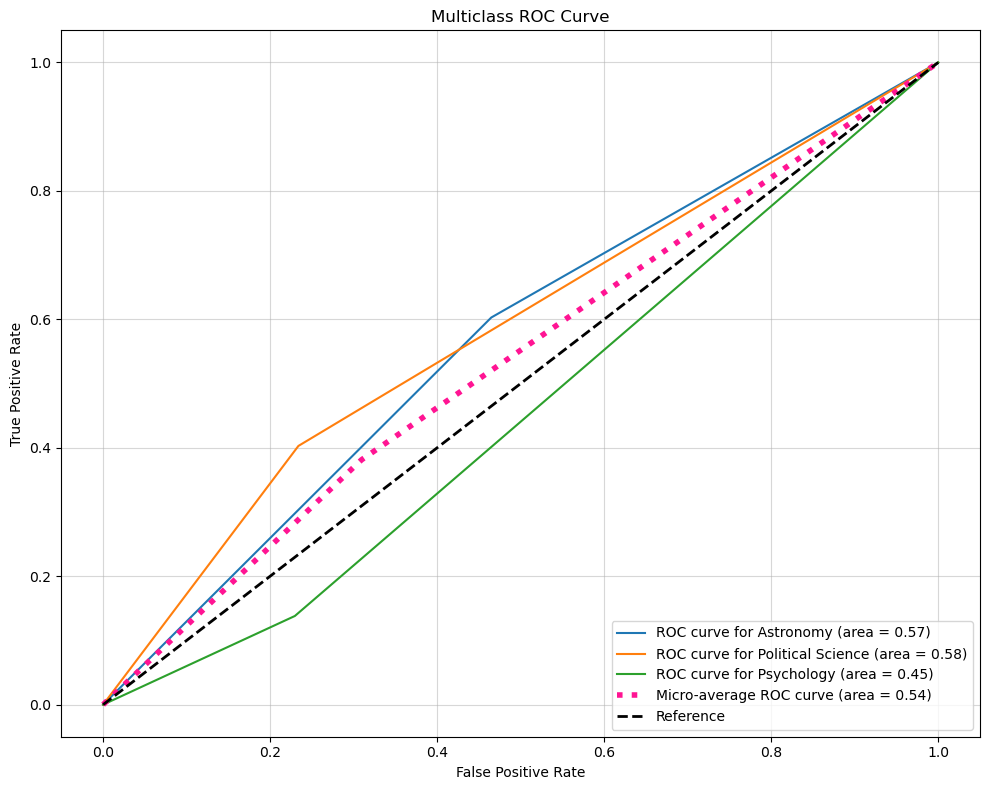

In [31]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Assume the classes are ['Astronomy', 'Political Science', 'Psychology']
classes = ['Astronomy', 'Political Science', 'Psychology']
n_classes = len(classes)

# Convert `all_true_labels` and `all_predictions` to one-hot encoding
all_true_labels_one_hot = label_binarize(all_true_labels, classes=[0, 1, 2])  # Adjust the class indices as needed
all_predictions_one_hot = label_binarize(all_predictions, classes=[0, 1, 2])

# Compute ROC curve and ROC AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(all_true_labels_one_hot[:, i], all_predictions_one_hot[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and AUC
fpr["micro"], tpr["micro"], _ = roc_curve(all_true_labels_one_hot.ravel(), all_predictions_one_hot.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve for {classes[i]} (area = {roc_auc[i]:.2f})')

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC curve (area = {roc_auc["micro"]:.2f})',
         color='deeppink', linestyle=':', linewidth=4)

# Plot a diagonal line for reference
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Reference')

# Add labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc='lower right')
plt.grid(alpha=0.5)
plt.tight_layout()

# Save the plot
plt.savefig('multiclass_roc_curve.png')
plt.show()


## The image shows a multiclass ROC (Receiver Operating Characteristic) curve comparing the performance of a classifier across three different categories: Astronomy, Political Science, and Psychology. The micro-average ROC curve is also plotted.

=>x-axis: False Positive Rate (0.0 to 1.0)

=>Y-axis: True Positive Rate (0.0 to 1.0)

=>Reference line: Represents random classifier performance (0.5 AUC)

=>Micro-average: Aggregate performance across all classes

## Plotting the Loss and Accuracy Per Epoch

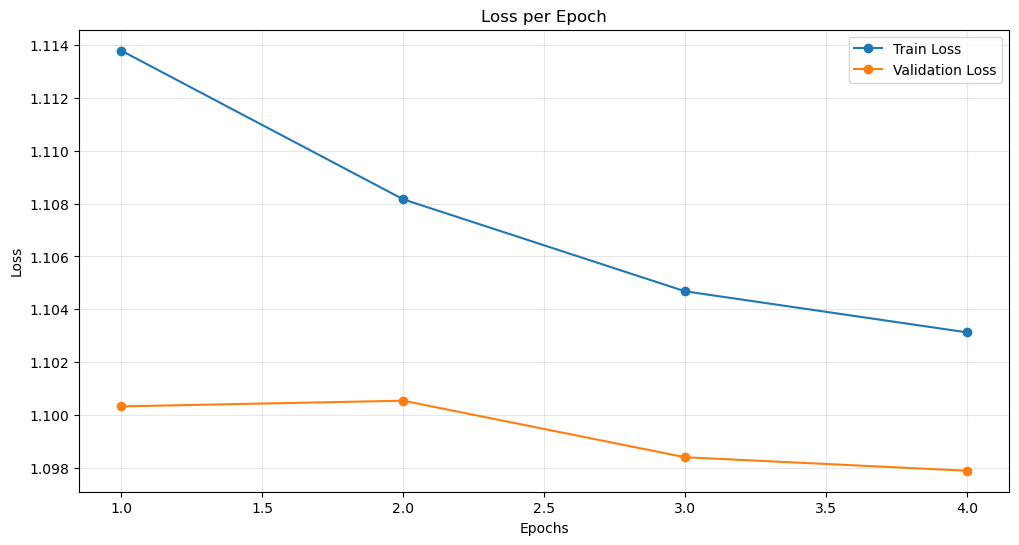

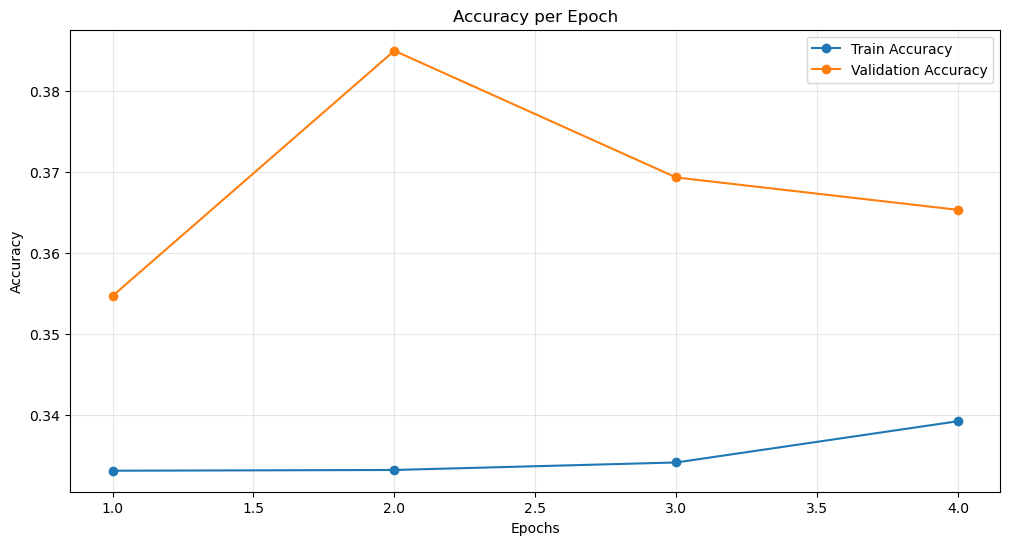

In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Example Data (Replace these with the actual metrics from the code)
# These are 5 folds of train/validation losses and accuracies for 4 epochs each


# Calculate averages across folds
avg_train_losses = np.mean(all_folds_train_losses, axis=0)
avg_val_losses = np.mean(all_folds_val_losses, axis=0)
avg_train_accuracies = np.mean(all_folds_train_accuracies, axis=0)
avg_val_accuracies = np.mean(all_folds_val_accuracies, axis=0)

# Plot Losses
plt.figure(figsize=(12, 6))
epochs = range(1, len(avg_train_losses) + 1)
plt.plot(epochs, avg_train_losses, label='Train Loss', marker='o')
plt.plot(epochs, avg_val_losses, label='Validation Loss', marker='o')
plt.title('Loss per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot Accuracies
plt.figure(figsize=(12, 6))
plt.plot(epochs, avg_train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs, avg_val_accuracies, label='Validation Accuracy', marker='o')
plt.title('Accuracy per Epoch')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


**Loss per Epoch (Graph 1)**

=> X-axis: Epochs (range: 1.0 to 4.0)

=> Y-axis: Loss (range: 1.098 to 1.114)

=> Legend: Train Loss (blue), Validation Loss (orange)

=> Graph type: Line plot with markers

**Accuracy per Epoch (Graph 2)**

=> X-axis: Epochs (range: 1.0 to 4.0)

=> Y-axis: Accuracy (range: 0.33 to 0.39)

=> Legend: Train Accuracy (blue), Validation Accuracy (orange)

=> Graph type: Line plot with markers

## Plotting the Confusion Matrix

In [32]:
from sklearn.metrics import confusion_matrix

# Calculate the confusion matrix using sklearn's confusion_matrix function
cm = confusion_matrix(all_true_labels, all_predictions)

# Saving the picture as a .txt file
print("Confusion Matrix:")
print(cm)
with open('confusion_matrix1.txt', 'w') as f:
    f.write(str(cm))

Confusion Matrix:
[[214  50  91]
 [140 143  72]
 [190 116  49]]


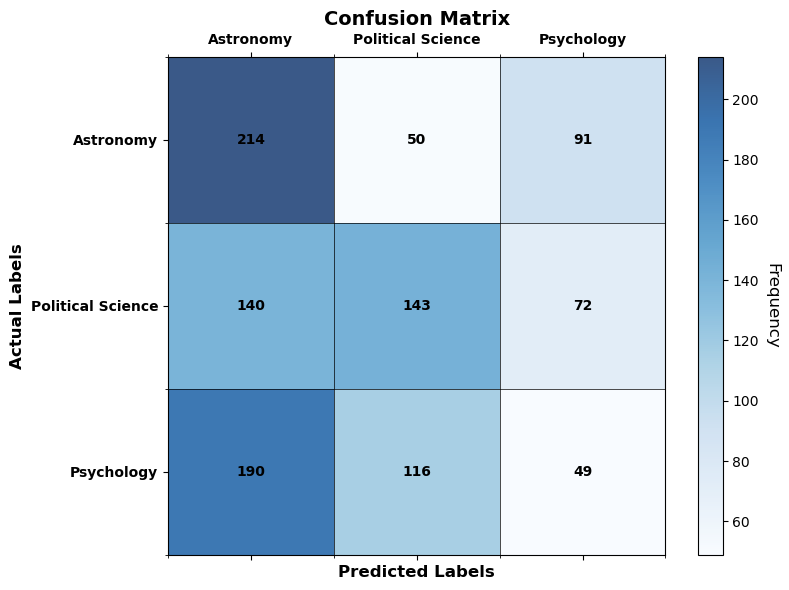

In [27]:
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
cm = np.array([[214,  50,  91],
               [140, 143,  72],
               [190, 116,  49]])

# Plotting the confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))

# Use a more visually appealing color map
cax = ax.matshow(cm, cmap='Blues', alpha=0.8)

# Adding color bar
cbar = plt.colorbar(cax)
cbar.ax.set_ylabel('Frequency', rotation=270, labelpad=15, fontsize=12)

# Adding annotations with bold formatting
for (i, j), val in np.ndenumerate(cm):
    ax.text(j, i, f'{val}', ha='center', va='center', 
            color='black', fontsize=10, weight='bold')

# Setting axis labels and title
plt.xlabel('Predicted Labels', fontsize=12, weight='bold')
plt.ylabel('Actual Labels', fontsize=12, weight='bold')
plt.title('Confusion Matrix', fontsize=14, weight='bold')

# Customizing tick labels
categories = ['Astronomy', 'Political Science', 'Psychology']
ax.set_xticks(range(len(categories)))
ax.set_yticks(range(len(categories)))
ax.set_xticklabels(categories, fontsize=10, weight='bold')
ax.set_yticklabels(categories, fontsize=10, weight='bold')

# Adding gridlines for better separation
ax.grid(False)  # Turn off default grid
ax.set_xticks(np.arange(-0.5, len(categories), 1), minor=True)
ax.set_yticks(np.arange(-0.5, len(categories), 1), minor=True)
ax.grid(which="minor", color="black", linestyle='-', linewidth=0.5)

# Saving the plot
plt.tight_layout()
plt.savefig('confusion_matrix_1.png', dpi=300)
plt.show()


**Astronomy**

True Positives (TP): 214. The model correctly predicted 214 instances as 'Astronomy'.

False Positives (FP): 50. The model incorrectly predicted 50 instances as 'Astronomy' when they were actually 'Political Science'.

False Negatives (FN): 91. The model incorrectly predicted 91 instances as 'Political Science' or 'Psychology' when they were actually 'Astronomy'.

True Negatives (TN): Not explicitly shown. This represents the number of instances correctly classified as 'Political Science' and 'Psychology'.

**Political Science**

True Positives (TP): 143. The model correctly predicted 143 instances as 'Political Science'.

False Positives (FP): 140. The model incorrectly predicted 140 instances as 'Political Science' when they were actually 'Astronomy'.

False Negatives (FN): 72. The model incorrectly predicted 72 instances as 'Astronomy' or 'Psychology' when they were actually 'Political Science'.

True Negatives (TN): Not explicitly shown. This represents the number of instances correctly classified as 'Astronomy' and 'Psychology'.

**Psychology**

True Positives (TP): 49. The model correctly predicted 49 instances as 'Psychology'.

False Positives (FP): 190. The model incorrectly predicted 190 instances as 'Psychology' when they were actually 'Astronomy'.

False Negatives (FN): 116. The model incorrectly predicted 116 instances as 'Astronomy' or 'Political Science' when they were actually 'Psychology'.

True Negatives (TN): Not explicitly shown. This represents the number of instances correctly classified as 'Astronomy' and 'Political Science'.
